In [92]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import random
import string
from collections import defaultdict
from itertools import product, chain
import numpy as np
from pattern.en import comparative

import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
import torch
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from enum import Enum
from typing import List, Optional, Union

from child_frames import frames
from utils import *

import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')

import dataclasses
import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Dict, Optional

from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, GlueDataset
from transformers import GlueDataTrainingArguments as DataTrainingArguments
from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
from transformers import RobertaForMaskedLM, RobertaTokenizer
from transformers.modeling_roberta import RobertaDoubleHeadsModel  # XD

logging.basicConfig(level=logging.ERROR)

In [162]:
A_template = "{rel_prefix} {dt} {ent0} {rel} {dt} {ent1} {rel_suffix}"
B_templates = ["{pred_prefix} {dt} {ent} {pred}", "{pred_prefix} {pred} {dt} {ent}"]
B_template = B_templates[0]
entailment_templates = [
    "{A} ? {conj} , {B} .",  # yes/no/maybe
    "{A} , so {B} ? {conj} .",
]
marker = '*'
def get_comparative(word, add_marker=True):
    compar = comparative(word)
    if add_marker:
        compar = compar.replace('more ', 'more %s ' % marker) if compar.startswith('more ') else marker + ' ' + compar
    return compar
    
def negate_sent(sent):
    assert ' is ' in sent
    neg_sents = []
    neg_sent0 = sent.replace(' is ', ' is not ') if 'more ' not in sent else sent.replace('more ', 'less ')
    neg_sents.append(neg_sent0)
    neg_sents.append('it is unlikely that ' + sent)
    return neg_sents

def strip_rel_id(s, lexical_rel=''):
    rel_id_span = s[s.index(':'): s.index(':') + 2]
    if lexical_rel != '': lexical_rel = ' ( ' + lexical_rel + ' )'
    return s.replace(rel_id_span, lexical_rel)
        
tag2id = {'Ġsame': 0, 'Ġopposite': 1, 'Ġunrelated': 2, 'Ġformer': 3, 'Ġlatter': 4, 'Ġanother': 5}
id2tag = {v: k for k, v in tag2id.items()}

def make_sentences(index=-1, entities=["_X", "_Z"], entity_set=string.ascii_uppercase, determiner="",
                   relation_group=[["big",], ["small"]], rand_relation_group=[["short"], ["tall", "high"]],
                   relation_prefix="", relation_suffix="", predicate_prefix="",
                   n_entity_trials=3, has_negA=True, has_negB=True, has_neutral=False, mask_types={'sent_rel'}, 
                   lexical_relations=['same', 'opposite', 'unrelated'], tag_lexical_rel=False, tag_entity_rel=False):
    if tag_lexical_rel: mask_types.add('lexical_rel')
    if tag_entity_rel: mask_types.add('entity_rel')
        
    def form_As(relations):
        return [A_template.format(dt=determiner, ent0=ent0, ent1=ent1, rel=rel, rel_prefix=relation_prefix, rel_suffix=relation_suffix)
              for ent0, ent1, rel in [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]

    As = []
    for rel0 in relation_group[0]:
        for rel1 in relation_group[1]:
            relations = ["is %s:%d than" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
            As += form_As(relations)
    As = list(set(As))
    negAs = join_lists([negate_sent(A)[:1] for A in As]) if has_negA else []

    def form_Bs(predicates): 
        f = mask if 'entity' in mask_types else (lambda x: x)
        return [B_template.format(dt=determiner, ent=f(ent), pred=pred, pred_prefix=predicate_prefix)
              for ent, pred in zip(entities, predicates)]

    Bs, negBs = {'orig': [], 'rand': []}, {}
    for k, group in zip(['orig', 'rand'], [relation_group, rand_relation_group]):
        for rel0 in group[0]:
            for rel1 in group[1]:
                predicates = ["is %s:%d" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
                Bs[k] += form_Bs(predicates)
    for k in Bs:
        Bs[k] = list(set(Bs[k]))
        if has_negB:
            negBs[k] = join_lists([negate_sent(B)[:1] for B in Bs[k]])
            Bs[k], negBs[k] = Bs[k] + [swap_entities(negB) for negB in negBs[k]], negBs[k] + [swap_entities(B) for B in Bs[k]]
        else:
            negBs[k] = [swap_entities(B) for B in Bs[k]]

    def form_sentences(sentence_template, As, Bs, conj):
        def extract_rel_id(s): return int(s[s.index(':') + 1])
        def get_lexical_rel(rel_id_A, rel_id_B): return 'same' if rel_id_A == rel_id_B else 'opposite'
        def compare_and_tag_entity(B, A):
            entity = [e for e in entities if e in B][0]
            entity_rel = 'former' if A.strip().startswith(entity) else 'latter'
            if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
            return B.replace(entity, entity + ' ( ' + entity_rel + ' )')                    
        
        if 'sent_rel' in mask_types: conj = mask(conj)
        As_with_rel_ids = [(A, extract_rel_id(A)) for A in As]
        Bs_with_rel_ids = [(B, extract_rel_id(B)) for B in Bs]
            
        sentences = []
        for (A, rel_id_A), (B, rel_id_B) in product(As_with_rel_ids, Bs_with_rel_ids):
            lexical_rel = 'unrelated' if 'Maybe' in conj else get_lexical_rel(rel_id_A, rel_id_B)
            if lexical_rel in lexical_relations:
                if tag_entity_rel: B = compare_and_tag_entity(B, A)
                if not tag_lexical_rel: lexical_rel = ''
                elif 'lexical_rel' in mask_types: lexical_rel = mask(lexical_rel)
                sent = sentence_template.format(A=strip_rel_id(A), B=strip_rel_id(B, lexical_rel), conj=conj)
                sent = " " + " ".join(sent.split())
                sentences.append(sent)
        return sentences

    sentences = defaultdict(list)
    for entailment_template in entailment_templates[-1:]:
        for A, B, conj in [(As, Bs['orig'], 'Right'), 
                           (negAs, negBs['orig'], 'Right'), 
                           (As, negBs['orig'], 'Wrong'), 
                           (negAs, Bs['orig'], 'Wrong'),
                           (As, Bs['rand'], 'Maybe'), 
                           (negAs, negBs['rand'], 'Maybe'), 
                           (As, negBs['rand'], 'Maybe'), 
                           (negAs, Bs['rand'], 'Maybe'),
                          ]:
            sentences[conj] += form_sentences(entailment_template, A, B, conj)
    assert len(sentences['Right']) == len(sentences['Wrong']), '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    if has_neutral: sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    sentences = join_lists(sentences[k] for k in (sentences.keys() if has_neutral else ['Right', 'Wrong']))
    
    substituted_sent_groups = []
    for sent in sentences:
        sent_group = []
        for _ in range(n_entity_trials):
            e0, e1 = random.sample(entity_set, 2)
            sent_group.append(sent.replace(entities[0], e0).replace(entities[1], e1))
        substituted_sent_groups.append(sent_group)
    return sentences, substituted_sent_groups

# make_sentences(has_negA=True, has_negB=True, has_neutral=False, tag_lexical_rel=True, tag_entity_rel=True, 
#                mask_types={'sent_rel'})[0]

([' _X is * bigger than _Z , so _Z ( [ latter ] ) is * smaller ( [ opposite ] ) ? [ Right ] .',
  ' _X is * bigger than _Z , so _X ( [ former ] ) is * bigger ( [ same ] ) ? [ Right ] .',
  ' _X is * bigger than _Z , so _X ( [ former ] ) is not * smaller ( [ opposite ] ) ? [ Right ] .',
  ' _X is * bigger than _Z , so _Z ( [ latter ] ) is not * bigger ( [ same ] ) ? [ Right ] .',
  ' _Z is * smaller than _X , so _Z ( [ former ] ) is * smaller ( [ same ] ) ? [ Right ] .',
  ' _Z is * smaller than _X , so _X ( [ latter ] ) is * bigger ( [ opposite ] ) ? [ Right ] .',
  ' _Z is * smaller than _X , so _X ( [ latter ] ) is not * smaller ( [ same ] ) ? [ Right ] .',
  ' _Z is * smaller than _X , so _Z ( [ former ] ) is not * bigger ( [ opposite ] ) ? [ Right ] .',
  ' _X is not * bigger than _Z , so _Z ( [ latter ] ) is not * smaller ( [ opposite ] ) ? [ Right ] .',
  ' _X is not * bigger than _Z , so _X ( [ former ] ) is not * bigger ( [ same ] ) ? [ Right ] .',
  ' _X is not * bigger than _

In [18]:
P_template = '{ent0} {rel} {ent1}'
transitive_template = '{p0} and {p1} , so {Q} ? {conj} .'
transitive_wh_QA_template = '{which} is {pred} ? {ent} .'
    
def make_transitive(entities=["_X", "_Y", "_Z"], entity_set=string.ascii_uppercase, relation_group=[["big", ], ["small", ]], 
                    n_entity_trials=3, has_negP=True, has_negQ=True, has_neutral=False, mask_types=['sent_rel']):
    def form_atoms(relations, entities, has_neg=True):
        atoms = [P_template.format(ent0=ent0, ent1=ent1, rel=rel) 
                 for ent0, ent1, rel in [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
        if has_neg:
            neg_relations = [r.replace('is ', 'is not ') for r in relations]
            atoms += [P_template.format(ent0=ent0, ent1=ent1, rel=rel) 
                      for ent0, ent1, rel in [entities + reverse(neg_relations)[:1], reverse(entities) + neg_relations[:1]]]
        return atoms
 
    def form_sentences(transitive_template, Ps, Qs, conj):
        sentences = []
        if 'sent_rel' in mask_types: conj = mask(conj)
        for (p0, p1), Q in product(Ps, Qs):
            sent = transitive_template.format(p0=strip_rel_id(p0), p1=strip_rel_id(p1), Q=strip_rel_id(Q), conj=conj)
            sent = " " + " ".join(sent.split())
            sentences.append(sent)
        return sentences
    
    def form_all(P0_entities, P1_entities, Q_entities, neutral=False):
        P0, P1 = [], []
        for rel0 in relation_group[0]:
            for rel1 in relation_group[1]:
                relations = ["is %s:%d than" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
                P0 += form_atoms(relations, P0_entities, has_neg=has_negP)
                P1 += form_atoms(relations, P1_entities, has_neg=has_negP)
        Ps = [(p0, p1) for p0, p1 in list(product(P0, P1)) + list(product(P1, P0))]

        Qs = form_atoms(relations, Q_entities, has_neg=has_negQ)
        negQs = [swap_entities(Q, *Q_entities) for Q in Qs]
        
        for P, Q, conj in [(Ps, Qs, 'Right'), (Ps, negQs, 'Wrong')]:
            if neutral: conj = 'Maybe'
            sentences[conj] += form_sentences(transitive_template, P, Q, conj)
        return sentences
    
    e0, e1, e2 = entities
    sentences = defaultdict(list)
    form_all(P0_entities=[e0, e1], P1_entities=[e1, e2], Q_entities=[e0, e2])
    assert len(sentences['Right']) == len(sentences['Wrong']), '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    sample_ratio = len(relation_group[0]) * len(relation_group[1])
    if sample_ratio > 1:
        for key in sentences: sentences[key] = random.sample(sentences[key], len(sentences[key]) // sample_ratio)
#     print('nRight =', len(sentences['Right']))
    if has_neutral:
        form_all(P0_entities=[e0, e1], P1_entities=[e0, e2], Q_entities=[e1, e2], neutral=True)
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    sentences = join_lists(sentences[k] for k in (sentences.keys() if has_neutral else ['Right', 'Wrong']))
    
    substituted_sent_groups = []
    for sent in sentences:
        sent_group = []
        for _ in range(n_entity_trials):
            e0, e1, e2 = random.sample(entity_set, 3)
            sent_group.append(sent.replace(entities[0], e0).replace(entities[1], e1).replace(entities[2], e2))
        substituted_sent_groups.append(sent_group)
    return sentences, substituted_sent_groups

# make_transitive(has_negP=False, has_negQ=False, has_neutral=False)

([' _X is bigger than _Y and _Y is bigger than _Z , so _X is bigger than _Z ? [ Right ] .',
  ' _X is bigger than _Y and _Y is bigger than _Z , so _Z is smaller than _X ? [ Right ] .',
  ' _X is bigger than _Y and _Z is smaller than _Y , so _X is bigger than _Z ? [ Right ] .',
  ' _X is bigger than _Y and _Z is smaller than _Y , so _Z is smaller than _X ? [ Right ] .',
  ' _Y is smaller than _X and _Y is bigger than _Z , so _X is bigger than _Z ? [ Right ] .',
  ' _Y is smaller than _X and _Y is bigger than _Z , so _Z is smaller than _X ? [ Right ] .',
  ' _Y is smaller than _X and _Z is smaller than _Y , so _X is bigger than _Z ? [ Right ] .',
  ' _Y is smaller than _X and _Z is smaller than _Y , so _Z is smaller than _X ? [ Right ] .',
  ' _Y is bigger than _Z and _X is bigger than _Y , so _X is bigger than _Z ? [ Right ] .',
  ' _Y is bigger than _Z and _X is bigger than _Y , so _Z is smaller than _X ? [ Right ] .',
  ' _Y is bigger than _Z and _Y is smaller than _X , so _X is bigge

In [10]:
model_class, tokenizer_class, shortcut = RobertaForMaskedLM, RobertaTokenizer, 'roberta-large'
# model_class = RobertaDoubleHeadsModel
model, tokenizer = None, tokenizer_class.from_pretrained(shortcut)

In [96]:
random.shuffle(frames)
n_entity_trials = 5
all_lines = [make_sentences(relation_group=rg, rand_relation_group=frames[(i + 1) % len(frames)], n_entity_trials=n_entity_trials, 
                            has_negA=True, has_negB=True, tag_lexical_rel=True, tag_entity_rel=True,
                            has_neutral=False, mask_types={'sent_rel'})[1] 
             for i, rg in enumerate(frames)]
# all_lines = [make_transitive(relation_group=rg, n_entity_trials=10, 
#                              has_negP=False, has_negQ=False, has_neutral=False, mask_types=['sent_rel'])[1] 
#              for i, rg in enumerate(frames)]
# all_lines = join_lists(all_lines)
# all_lines = join_lists(all_lines)
tokenizer.tag2id, tokenizer.id2tag = tag2id, id2tag
for k in CHILDDataset.all_lines: CHILDDataset.all_lines[k] = None
train_dataset = CHILDDataset(all_lines, tokenizer, has_markers=True, max_noise_len=0, split_pct=[0.7, 0.3, 0.0], mode='train')
eval_dataset = CHILDDataset(all_lines, tokenizer, has_markers=True, max_noise_len=0, split_pct=[0.7, 0.3, 0.0], mode='dev')
print('nTrain = %d, nValid = %d' % (len(train_dataset), len(eval_dataset)))

in convert_example_to_features: features.labels = [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 5442, -100, -100, -100, -100, 5483, -100, -100, 5143, -100, -100, -100, -100, -100, -100, -100, -100, -100]
in convert_example_to_features: features.labels = [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 5442, -100, -100, -100, -100, -100, 5483, -100, -100, 5143, -100, -100, -100, -100]
nTrain = 16680, nValid = 7880


In [97]:
model = model_class.from_pretrained('roberta-base', model=model)
steps = int(round(100 * n_entity_trials / 3))
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=32, per_device_eval_batch_size=64,
    learning_rate=2e-5, num_train_epochs=3,
    logging_steps=steps, eval_steps=steps, save_steps=0,
    no_cuda=False, evaluate_during_training=True,
)
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)
trainer.tokenizer = tokenizer
trainer.train()

{'loss': 0.499, 'learning_rate': 1.7867177522349936e-05, 'epoch': 0.32, 'step': 167}



{'eval_loss': 0.397, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.92, 'eval_stat_1': 'Ġsame 0.53 0.98, Ġopposite 0.47 0.98, ', 'eval_acc_2': 0.504, 'eval_stat_2': 'ĠWrong 1.00 0.74, ', 'epoch': 0.32, 'step': 167}
{'loss': 0.247, 'learning_rate': 1.5734355044699873e-05, 'epoch': 0.64, 'step': 334}



{'eval_loss': 0.466, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.923, 'eval_stat_1': 'Ġsame 0.50 0.99, Ġopposite 0.50 0.99, ', 'eval_acc_2': 0.504, 'eval_stat_2': 'ĠWrong 1.00 0.67, ', 'epoch': 0.64, 'step': 334}
{'loss': 0.242, 'learning_rate': 1.3601532567049809e-05, 'epoch': 0.96, 'step': 501}



{'eval_loss': 0.4, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.943, 'eval_stat_1': 'Ġsame 0.51 0.99, Ġopposite 0.49 0.99, ', 'eval_acc_2': 0.504, 'eval_stat_2': 'ĠWrong 1.00 0.55, ', 'epoch': 0.96, 'step': 501}



{'loss': 0.239, 'learning_rate': 1.1468710089399747e-05, 'epoch': 1.28, 'step': 668}



{'eval_loss': 0.431, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.952, 'eval_stat_1': 'Ġsame 0.51 1.00, Ġopposite 0.49 1.00, ', 'eval_acc_2': 0.504, 'eval_stat_2': 'ĠWrong 1.00 0.61, ', 'epoch': 1.28, 'step': 668}
{'loss': 0.239, 'learning_rate': 9.33588761174968e-06, 'epoch': 1.6, 'step': 835}



{'eval_loss': 0.435, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.948, 'eval_stat_1': 'Ġsame 0.51 1.00, Ġopposite 0.49 1.00, ', 'eval_acc_2': 0.496, 'eval_stat_2': 'ĠRight 1.00 0.56, ', 'epoch': 1.6, 'step': 835}
{'loss': 0.236, 'learning_rate': 7.2030651340996175e-06, 'epoch': 1.92, 'step': 1002}



{'eval_loss': 0.456, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.95, 'eval_stat_1': 'Ġsame 0.50 1.00, Ġopposite 0.50 0.99, ', 'eval_acc_2': 0.504, 'eval_stat_2': 'ĠWrong 1.00 0.58, ', 'epoch': 1.92, 'step': 1002}



{'loss': 0.234, 'learning_rate': 5.070242656449553e-06, 'epoch': 2.239, 'step': 1169}



{'eval_loss': 0.445, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.944, 'eval_stat_1': 'Ġsame 0.50 1.00, Ġopposite 0.50 0.99, ', 'eval_acc_2': 0.504, 'eval_stat_2': 'ĠWrong 1.00 0.63, ', 'epoch': 2.239, 'step': 1169}
{'loss': 0.143, 'learning_rate': 2.9374201787994896e-06, 'epoch': 2.559, 'step': 1336}



{'eval_loss': 0.344, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.952, 'eval_stat_1': 'Ġsame 0.49 1.00, Ġopposite 0.51 1.00, ', 'eval_acc_2': 0.859, 'eval_stat_2': 'ĠRight 0.51 0.93, ĠWrong 0.49 0.93, ', 'epoch': 2.559, 'step': 1336}
{'loss': 0.068, 'learning_rate': 8.045977011494253e-07, 'epoch': 2.879, 'step': 1503}



{'eval_loss': 0.362, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.95, 'eval_stat_1': 'Ġsame 0.50 1.00, Ġopposite 0.50 1.00, ', 'eval_acc_2': 0.879, 'eval_stat_2': 'ĠRight 0.50 0.95, ĠWrong 0.50 0.95, ', 'epoch': 2.879, 'step': 1503}





{'eval_loss': 0.365, 'eval_acc_0': 1.0, 'eval_stat_0': 'Ġformer 0.50 1.00, Ġlatter 0.50 1.00, ', 'eval_acc_1': 0.95, 'eval_stat_1': 'Ġsame 0.50 1.00, Ġopposite 0.50 1.00, ', 'eval_acc_2': 0.881, 'eval_stat_2': 'ĠRight 0.52 0.96, ĠWrong 0.48 0.96, ', 'epoch': 3.0, 'step': 1566}


TrainOutput(global_step=1566, training_loss=0.23126971515402256)

In [98]:
dataloader = DataLoader(
    eval_dataset,
    sampler=RandomSampler(eval_dataset),
    batch_size=trainer.args.eval_batch_size,
    collate_fn=trainer.data_collator,
    drop_last=trainer.args.dataloader_drop_last,
)

In [99]:
for inputs in dataloader: break

In [100]:
inputs['marked_positions'].size()

torch.Size([64, 2])

In [141]:
for i in range(20):
    print(i, tokenizer.decode(inputs['input_ids'][i]), 
          [tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[j] for j in inputs['marked_positions'][i]])

0 <s>E is more moral than J, so J (<mask> ) is less moral (<mask> )?<mask>.</s><s><s> ['Ġmoral', 'Ġmoral']
1 <s>K is more arrogant than E, so E (<mask> ) is more arrogant (<mask> )?<mask>.</s><s><s> ['Ġarrogant', 'Ġarrogant']
2 <s>Y is more empirical than N, so N (<mask> ) is more empirical (<mask> )?<mask>.</s><s><s> ['Ġempirical', 'Ġempirical']
3 <s>O is less insufficient than V, so O (<mask> ) is less insufficient (<mask> )?<mask>.</s><s><s> ['Ġinsufficient', 'Ġinsufficient']
4 <s>C is nearer than G, so G (<mask> ) is less distant (<mask> )?<mask>.</s><s><s><s> ['Ġnearer', 'Ġdistant']
5 <s>U is more unhappy than P, so U (<mask> ) is more unhappy (<mask> )?<mask>.</s><s><s> ['Ġunhappy', 'Ġunhappy']
6 <s>M is not shorter than B, so M (<mask> ) is not shorter (<mask> )?<mask>.</s><s><s> ['Ġshorter', 'Ġshorter']
7 <s>X is tighter than P, so X (<mask> ) is not tighter (<mask> )?<mask>.</s><s><s><s> ['Ġtighter', 'Ġtighter']
8 <s>E is not longer than H, so H (<mask> ) is not shorter (<mask

In [137]:
_ = model.eval()
inputs = trainer._prepare_inputs(inputs, model)
with torch.no_grad():
    loss, logits, attns = model(**inputs, output_attentions=True)

attn_scores, attn_probs = zip(*attns)
attn_scores, attn_probs = torch.stack(attn_scores, dim=0), torch.stack(attn_probs, dim=0)
attn_probs = attn_probs.cpu()

In [158]:
def normalize_tokens(tokens):
    return ['@' + token if not token.startswith('Ġ') and token not in ['<s>', '</s>', '<mask>'] else token.replace('Ġ', '') 
                  for token in tokens] 

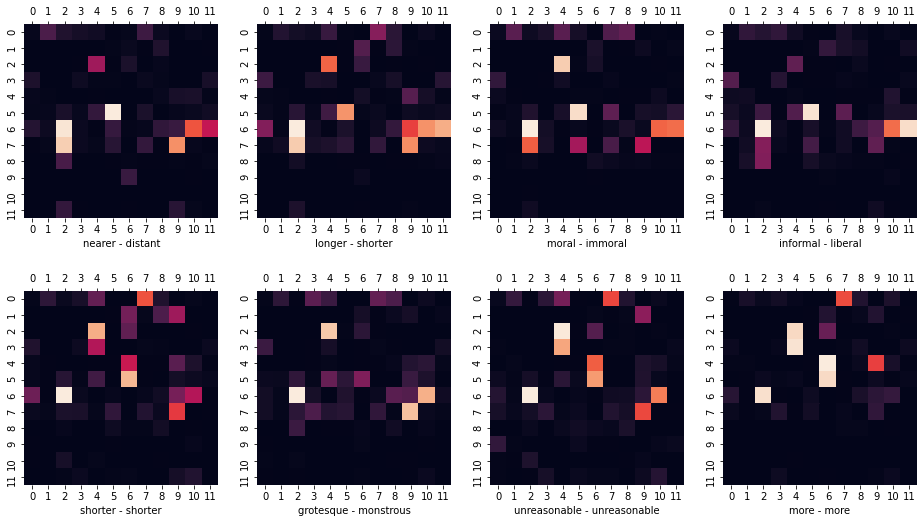

In [159]:
sample_indices = [[4, 8, 10, 12], 
                  [6, 9, 15, 18]]
n_rows, n_cols = len(sample_indices), len(sample_indices[0])
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(4 * n_cols, 4.5 * n_rows))
for row in range(n_rows):
    for col in range(n_cols):
        i, ax = sample_indices[row][col], axs[row][col]
        p, h = inputs['marked_positions'][i]
        p, h = p.item(), h.item()
        pos_attn = attn_probs[:, i, :, h, p]
        tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]))
        ax = sns.heatmap(pos_attn, square=True, cbar=False, ax=ax)
        ax.tick_params(top=True, labeltop=True)
        _ = ax.set_xlabel('%s - %s' % (tokens[p], tokens[h]))

tensor(22, device='cuda:0')

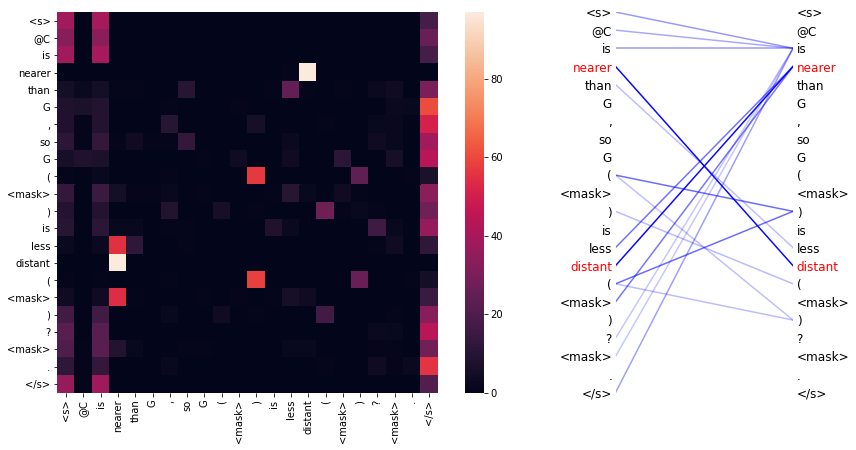

In [175]:
i = 4
layer, head = 5, 5
seq_len = inputs['attention_mask'][4].sum().item()
attn =  attn_probs[layer, i, head, : seq_len, : seq_len]
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[: seq_len])
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
_ = sns.heatmap((attn * 100).long(), square=True, cbar=True, annot=False, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)
plot_head_attn(attn, tokens, ax1=ax1, marked_positions=inputs['marked_positions'][i]) 

In [ ]:
model.roberta.encoder.layer[0].attention.self